# Convert data to EPOCHES

In [64]:
# Notebook 2
from pickleshare import PickleShareDB
db = PickleShareDB('./tmp')
raw = db['raw']
originalRaw = db['originalRaw']


### Test if we have our Raw Data

In [65]:
print(len(raw))
print(type(raw))
print(len(originalRaw))
print(type(originalRaw))

120000
<class 'mne.io.edf.edf.RawEDF'>
120000
<class 'mne.io.edf.edf.RawEDF'>


#### الحمد لله

## What are EPOCHES ?
In the context of EEG (Electroencephalogram) data analysis, an epoch refers to a segment of the continuous EEG recording that is time-locked to a specific event or stimulus. Epoching is a technique where the continuous EEG signal is divided into smaller, non-overlapping time windows, each centered around a particular event or marker.

Here's a brief explanation:

- **Epoching:**
  - **Purpose:** To extract and analyze EEG activity related to specific experimental events or conditions.
  - **Process:** The continuous EEG signal is divided into epochs, typically centered around events of interest, such as stimulus onset or response.
  - **Duration:** Each epoch is a fixed time window, capturing EEG activity before and after the event.
  - **Analysis:** Epochs can be averaged across trials to create event-related potentials (ERPs), revealing patterns of brain activity related to specific stimuli or tasks.

For example, in a visual experiment where participants respond to the presentation of a stimulus, epochs might be centered around the onset of the visual stimulus. This allows researchers to analyze the EEG activity associated with the processing of that stimulus.

Epoching is a fundamental step in EEG preprocessing for event-related analyses, providing a way to focus on specific time periods of interest and improving the signal-to-noise ratio for subsequent analysis.

In [66]:
!pip install seaborn

In [67]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os

from time import time

import mne
from mne.viz import plot_events
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn)
from mne.time_frequency import AverageTFR
from mne.channels import make_standard_montage
from mne.decoding import LinearModel, Vectorizer, get_coef, Scaler, CSP, SPoC, UnsupervisedSpatialFilter
mne.set_log_level('WARNING')

import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score, ShuffleSplit, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets

## What we need ?
fo epoching data we need events markers, Usually these are stored in the `raw` object (in MNE) in a stimulus channels.

In [68]:
# mne.find_events?

In [69]:
[events, events_ids] = mne.events_from_annotations(raw)
# mne.find_events(originalRaw)

`events` is simply an array (time in samples, zero, event trigered)

In [70]:
events[0:10]

array([[   0,    0,    5],
       [ 672,    0,    2],
       [1328,    0,    5],
       [2000,    0,    1],
       [2656,    0,    5],
       [3328,    0,    2],
       [3984,    0,    5],
       [4656,    0,    1],
       [5312,    0,    5],
       [5984,    0,    2]])

{'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4, 'rest': 5}


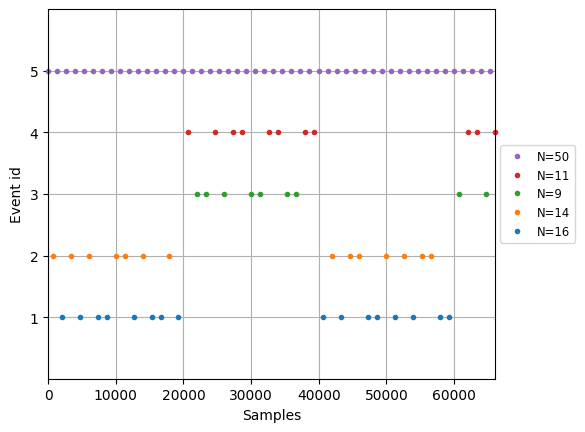

''

In [71]:
print(events_ids)
plot_events(events[:100])
;

In [72]:
epochs = Epochs(raw, events, event_id=events_ids, preload=True)
epochs

Number of events,174
Events,do/feet: 23do/hands: 22imagine/feet: 21imagine/hands: 24rest: 84
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [73]:
print(epochs.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 5.0 Hz
 lowpass: 20.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


In [74]:
# epochs.plot(n_channels=10, scalings=dict(eeg=50e-6))
# ;

============================================================[ imagine/hands ]============================================================


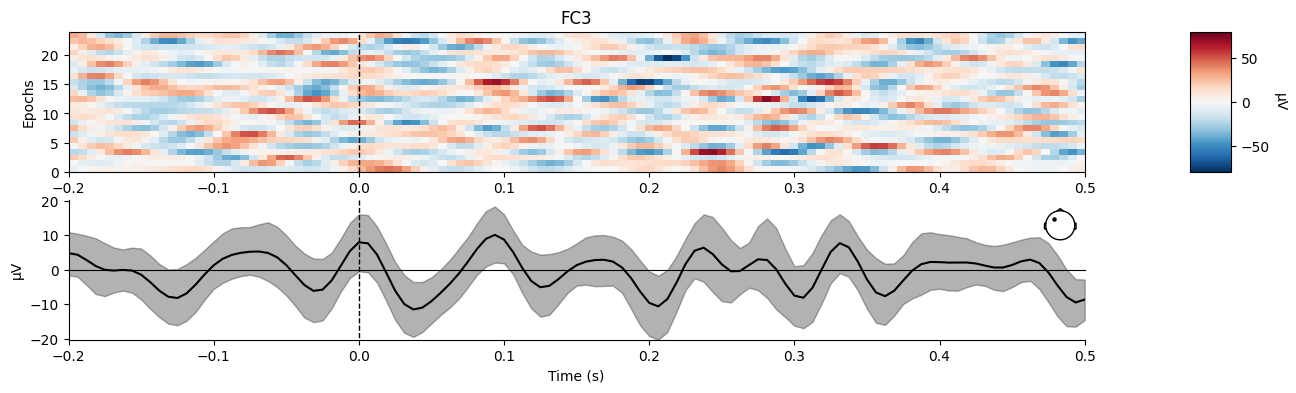

============================================================[ do/hands ]============================================================


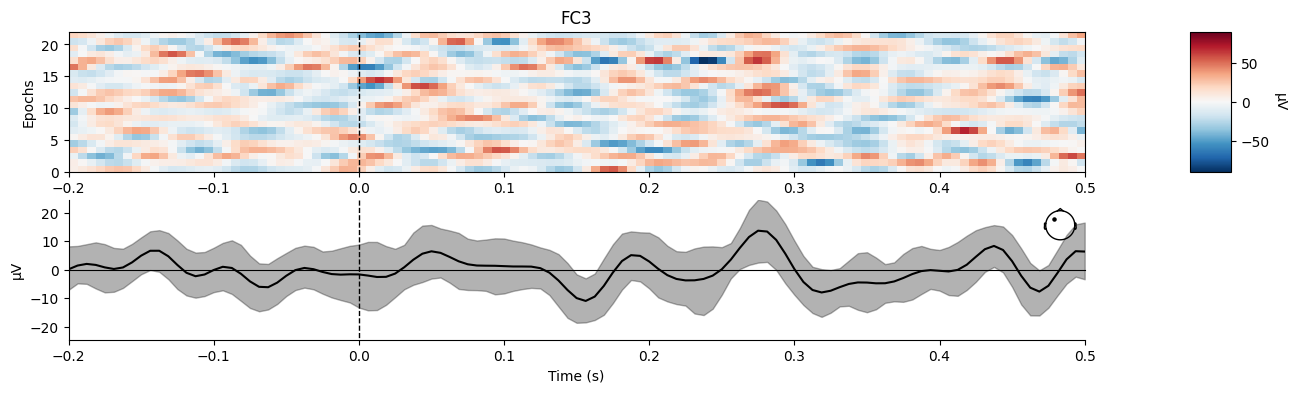

''

In [75]:
channelIdx = [1]
print("===" * 20 + "[ imagine/hands ]" + "===" * 20)
fgSize = (15, 4)
fig, axes = plt.subplots(figsize=fgSize, nrows=2, ncols=2, gridspec_kw={'width_ratios': [5, 0.2]})
# Plot the main image in the first frame of axes
# epochs["imagine/hands"].plot_image(picks=[13], axes=axes[0, 0])
# Remove the second column (axes[:, 1]) to leave space for axes2
for ax in axes[:, 1]:
    ax.remove()
# Create axes2 in the second row and second column
axes2 = plt.subplot(2, 2, 2)
# axes2.set_axis_off()  # Hide axes2 for plotting
# Pass axes_list to plot_image
epochs["imagine/hands"].plot_image(picks=channelIdx, fig=fig)
print("===" * 44)
print("===" * 20 + "[ do/hands ]" + "===" * 20)
fig, axes = plt.subplots(figsize=fgSize, nrows=2, ncols=2, gridspec_kw={'width_ratios': [5, 0.2]})
for ax in axes[:, 1]:
    ax.remove()
axes2 = plt.subplot(2, 2, 2)
epochs["do/hands"].plot_image(picks=channelIdx, fig=fig)
;

In [102]:
# evoked_feet = epochs['imagine/feet'].average()
# evoked_hand = epochs['imagine/hands'].average()

# evoked_feet.plot_joint(title='imagine/feet')
# evoked_hand.plot_joint(title='imagine/hands')
# plt.show()

In [103]:
# evoked_feet = epochs['do/feet'].average()
# evoked_hand = epochs['do/hands'].average()

# evoked_feet.plot_joint(title='do/feet')
# evoked_hand.plot_joint(title='do/hands')
# plt.show()

In [78]:
# pip install PyQt5
# epochs.equalize_event_counts(events_ids)
print(epochs)

<Epochs |  174 events (all good), -0.2 – 0.5 s, baseline -0.2 – 0 s, ~9.7 MB, data loaded,
 'do/feet': 23
 'do/hands': 22
 'imagine/feet': 21
 'imagine/hands': 24
 'rest': 84>


In [79]:
do = epochs['do'].average()
imagine = epochs['imagine'].average()

print(do)
print(imagine)

<Evoked | '0.51 × do/feet + 0.49 × do/hands' (average, N=45), -0.2 – 0.5 s, baseline -0.2 – 0 s, 64 ch, ~151 kB>
<Evoked | '0.47 × imagine/feet + 0.53 × imagine/hands' (average, N=45), -0.2 – 0.5 s, baseline -0.2 – 0 s, 64 ch, ~151 kB>


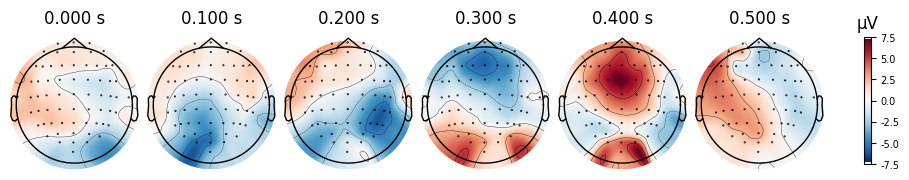

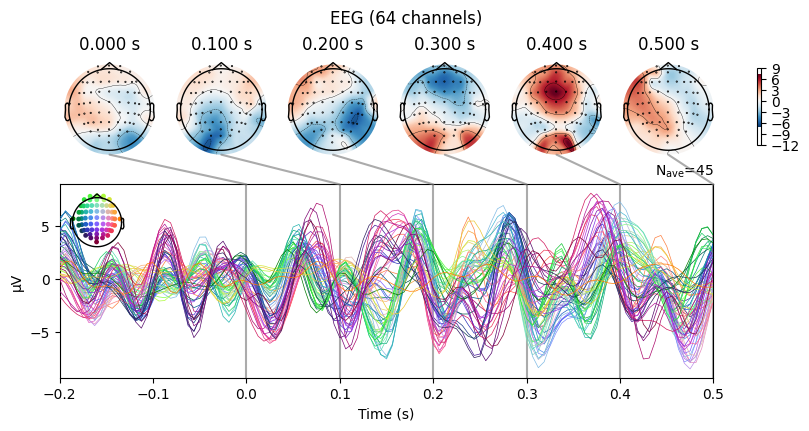

''

In [105]:
do.plot_topomap(times=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
do.plot_joint(times=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
;

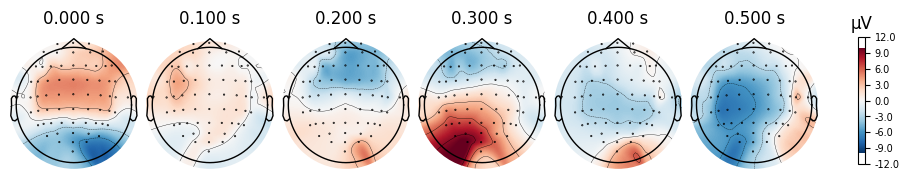

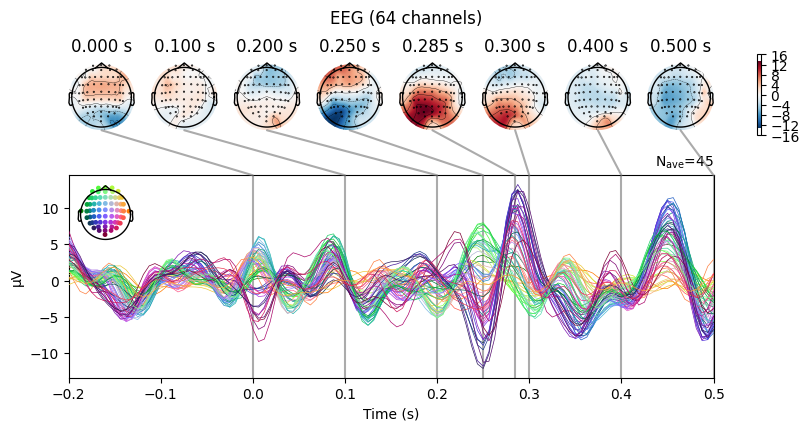

''

In [121]:
imagine.plot_topomap(times=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
# imagine.plot_joint(times=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
imagine.plot_joint(times=[0, 0.1, 0.2, 0.25, 0.285, 0.3, 0.4, 0.5])
;

## Shapes

In [89]:
print("Epoches shape          : ", epochs.get_data(copy=False).shape)
print("")
print("Epoches[do] shape      : ", epochs['do'].get_data(copy=False).shape)
print("do shape               : ", do.data.shape)
print("")
print("Epoches[imagine] shape : ", epochs['imagine'].get_data(copy=False).shape)
print("imagine shape          : ", imagine.data.shape)


Epoches shape          :  (174, 64, 113)

Epoches[do] shape      :  (45, 64, 113)
do shape               :  (64, 113)

Epoches[imagine] shape :  (45, 64, 113)
imagine shape          :  (64, 113)


In [113]:
diff = mne.combine_evoked((do, -imagine), weights="equal")

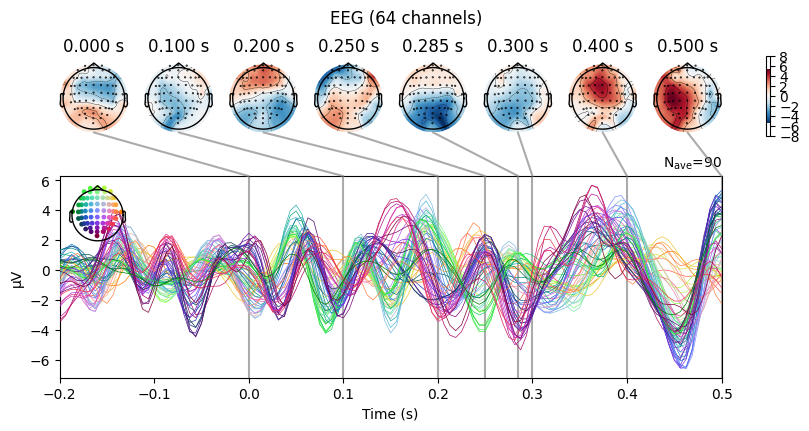

''

In [122]:
diff.plot_joint(times=[0, 0.1, 0.2, 0.25, 0.285, 0.3, 0.4, 0.5])
;

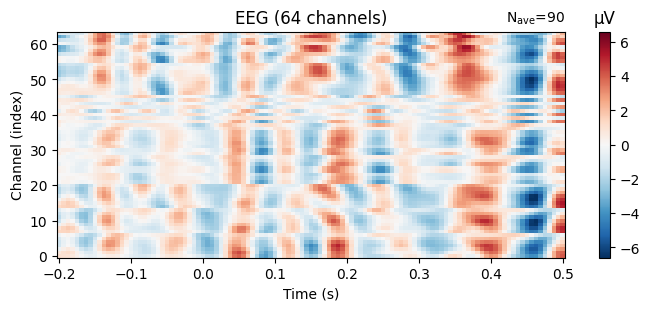

''

In [124]:
diff.plot_image()
;